In [88]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
from tqdm import tqdm
import random
import gymnasium as gym
# from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
from IPython.display import HTML
from collections import deque

In [89]:
'''
The environment used here is extremely similar to the openai gym ones.
At first glance it might look slightly different. 
The usual commands we use for our experiments are added to this cell to aid you
work using this environment.
'''

#Setting up the environment
env = gym.make('Taxi-v3', render_mode='rgb_array')
state, _ = env.reset()

# The state of the environment
print(state)

print("decoded state")
print(list(env.decode(state)))


#The number of states in the environment
print(env.observation_space.n)

#The number of actions in the environment
print(env.action_space.n)

#Take a step in the environment
print(env.step(1))
next_state, reward, done, _, _ = env.step(1)

#Render the environment
# env.render()

291
decoded state
[2, 4, 2, 3]
500
6
(191, -1, False, False, {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)})


In [90]:
total_options = 10
Q_values = np.zeros((env.observation_space.n, total_options))
print(Q_values.T[:6].T.shape)

# Softmax function
def softmax(Q_values, state, tau):
    q_values = Q_values[state]
    q_values = q_values / tau
    max_q = np.max(q_values)
    e = np.exp(q_values - max_q)
    dist = e / np.sum(e)
    action = np.random.choice(len(dist), p=dist)
    return action

(500, 6)


In [91]:
# actions:  ['up', 'right', 'down', 'left', 'pickup', 'dropoff']
actions = [0, 1, 2, 3, 4, 5]

# options: ['toR', 'toG', 'toY', 'toB']
options = [6, 7, 8, 9]

Q_options = np.zeros((len(options), 25, 4))

def execute_option(Q_values, option, state):
    optdone = False
    optact = 0
    goal_states = [[0, 0], [0, 4], [4, 0], [4, 3]]

    if option < 6:
        optact = softmax(Q_values=Q_values.T[6:].T, state=state, tau=1)
        optdone = True

    if option >= 6:
        decoded_state = list(env.decode(state))
        if decoded_state[0] == goal_states[option - 6][0] and decoded_state[1] == goal_states[option - 6][1]:
            optdone = True
        optact = softmax(Q_values=Q_options[option - 6], state=5*decoded_state[0] + decoded_state[1], tau=1)

    return optact, optdone

In [92]:
#### SMDP Q-Learning 
rewards = []
# Add parameters you might need here
gamma = 0.9
alpha = 0.3
# Iterate over 1000 episodes
for i in tqdm(range(10000)):
    state, _ = env.reset()    
    done = False
    rewards.append(0)
    # While episode is not over
    while not done:
        
        # Choose action        
        action = softmax(Q_values, state, tau=1)
        # Checking if primitive action
        if action < 6:
            # Perform regular Q-Learning update for state-action pair
            next_state, reward, done, _, _ = env.step(action)
            Q_values[state, action] += alpha * (reward + gamma * np.max(Q_values[next_state]) - Q_values[state, action])
            state = next_state
            rewards[i] += reward
            
            
        # Checking if action chosen is an option
        reward_bar = 0
        if action >= 6: # action => Away option
            count = 0
            optdone = False
            optact = 11
            current_state = state
            while (optdone == False):
                optact,optdone = execute_option(Q_options , action, state)
                next_state, reward, done, _, _ = env.step(optact)

                decoded_state = list(env.decode(state))
                decoded_next_state = list(env.decode(next_state))

                decoded_state_state = 5*decoded_state[0] + decoded_state[1]
                decoded_next_state_state = 5*decoded_next_state[0] + decoded_next_state[1]

                Q_options[ action - 6, decoded_state_state, optact] += alpha * (reward + gamma * np.max(Q_options[action - 6, decoded_next_state_state]) - Q_options[action - 6, decoded_state_state, optact ])

                reward_bar = reward_bar + gamma**count*reward
                count += 1
                rewards[i] += reward_bar
                if optdone == True:
                    Q_values[current_state, action] += alpha * (reward_bar - Q_values[current_state, action] + gamma**count * np.max(Q_values[next_state]))
                state = next_state


100%|██████████| 10000/10000 [02:00<00:00, 82.92it/s]


In [93]:
def plot_rewards(rewards):
    avg_rew = []
    plt.figure("Reward Plot")
    scores_window = deque(maxlen=300)
    for reward in rewards:
        scores_window.append(reward)
        avg_rew.append(np.mean(scores_window))
    plt.plot(avg_rew)

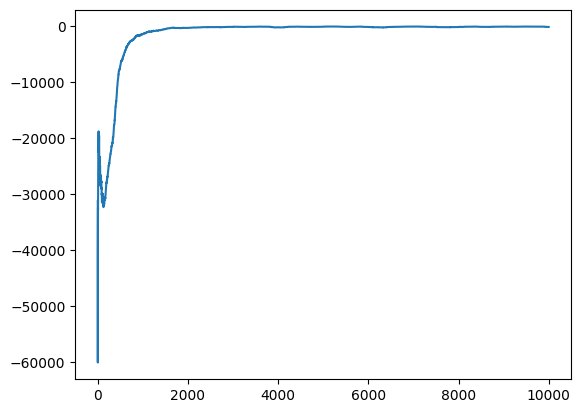

In [94]:
plot_rewards(rewards)

In [103]:
def options_plot(Q_options):
    GOAL_STATES = [[0, 0], [0, 4], [4, 0], [4, 3]]
    actions = ['up', 'right', 'down', 'left']
    integer = 0
    for i in Q_options:
        Q_map = np.zeros((5,5))
        for j in range(25):
            Q_map[j//5, j%5] = np.argmax(i[j])

        fig, ax = plt.subplots()
        ax.imshow(Q_map, cmap='viridis')

        # Plot goal states in black
        ax.text(GOAL_STATES[integer][1], GOAL_STATES[integer][0], 'X', color='black', fontsize=12, ha='center', va='center')
        for j in range(25):
            ax.text(j%5, j//5, actions[int(Q_map[j//5, j%5])], color='white', fontsize=12, ha='center', va='center')
        integer += 1
        # for x in range(5):
        #     for y in range(5):
        #         action = Q_map[x, y]
        #         dx = 0
        #         dy = 0
        #         if action == 0:  # up
        #             dy = -0.4
        #         elif action == 1:  # right
        #             dx = 0.4
        #         elif action == 2:  # down
        #             dy = 0.4
        #         elif action == 3:  # left
        #             dx = -0.4

        #         ax.annotate("", xy=(y+dx, x+dy), xytext=(y, x),
        #                     arrowprops=dict(arrowstyle="->", color='white'))
        
        
 

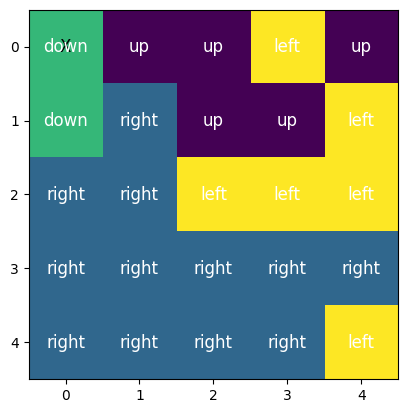

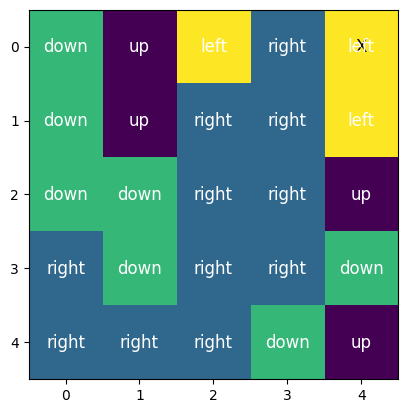

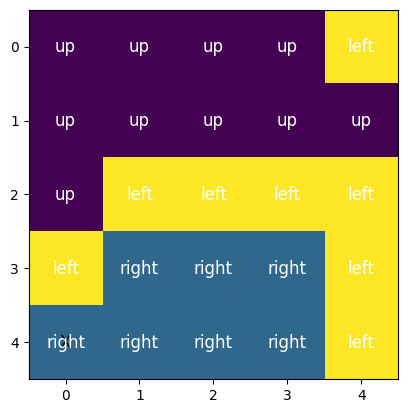

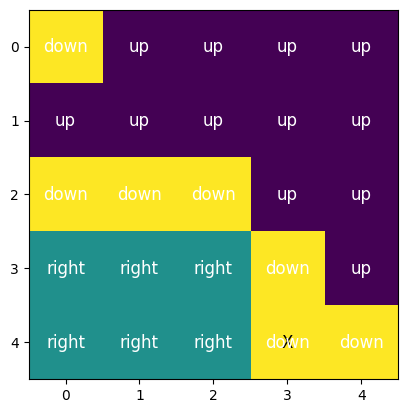

In [104]:
options_plot(Q_options)